In [1]:
# std lib
from getpass import getpass

# 3rd party
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from astropy.utils.data import download_file  #import file from URL
from scipy.stats import binned_statistic_2d
%matplotlib inline
from astropy.table import Table

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc
from dl.helpers.utils import convert

import astropy
from astropy import units as u
from astropy.coordinates import SkyCoord

print('Done importing')

Done importing


In [2]:
token = ac.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))

Enter user name: (+ENTER) yuxinhuang
Enter password: (+ENTER) ········


In [2]:
ac.whoAmI()

'yuxinhuang'

In [5]:
print(qc.schema('des_dr1'))


Schema: des_dr1

      Table Name   Description
      ----------   -----------
     des_allwise   ALLWISE 1-arcsec xmatch v. DES
       des_gaia2   Gaia DR2 1.5-arcsec xmatch v. DES
       des_galex   GALEX (AIS) 1-arcsec xmatch v. DES
        des_hsc2   HSC2 1-arcsec xmatch v. DES
      des_nscdr1   NSC DR1 1.5-arcsec xmatch v. DES
      des_simbad   SIMBAD 1-arcsec xmatch v. DES
            flux   Object flux table
       img2coadd   Images contributing to coadded tiles
             mag   Object magnitude table
            main   Main object table
       neighbors   Neighbors w/in 30-arcsec of each object
       tile_info   Survey tile information table
  x_gaia_dr2_2p5   Gaia DR1 2.5 arcsec xmatch v. DES



In [359]:
print(qc.schema('des_dr1.main'))


Schema: des_dr1
 Table: main

     Column Name   Description
     -----------   -----------
 coadd_object_id   Unique identifier for the coadded objects
         hpix_32   Healpix ID for nside=32, nested schema
         hpix_64   Healpix ID for nside=64, nested schema
       hpix_1024   Healpix ID for nside=1024, nested schema
       hpix_4096   Healpix ID for nside=4096, nested schema
      hpix_16384   Healpix ID for nside=16384, nested schema
              ra   Right ascension, with quantized precision for indexing (AL
                   PHAWIN_J2000 has full precision but not indexed)
             dec   Declination, with quantized precision for indexing (DELTAW
                   IN_J2000 has full precision but not indexed)
  alphawin_j2000   Right ascension for the object, J2000 in ICRS system (full
                   precision but not indexed)
  deltawin_j2000   Declination for the object, J2000 in ICRS (full precision 
                   but not indexed)
      galactic_l   Gala

In [4]:
c = SkyCoord(["21h44m25s -40d54m0s","21h33m24s -54d44m54s","21h49m23s -52d58m15s"], frame='icrs')

In [5]:
RA180924 = c[0].ra.degree
RA191001 = c[1].ra.degree
RA181112 = c[2].ra.degree

DEC180924 = c[0].dec.degree
DEC191001 = c[1].dec.degree
DEC181112 = c[2].dec.degree

print(RA180924, DEC180924)
print(RA191001, DEC191001)
print(RA181112, DEC181112)

# FRB180924
#ra = 326.1041666666667 dec = -40.9

#wide: ra_range = 1.4553 dec_range = 1.1
#narrow: ra_range = 0.0551 dec_range = 0.0417

# generate narrow list for calculating photometric redshift

In [24]:
# Write query statement (sql) as a string
# NOTE: triple quotes allow us to break the string on multiple lines
query = """
        SELECT coadd_object_id as id, mag_aper_8_r as rmag_aper, mag_auto_r as rmag,
               class_star_g, class_star_r, class_star_z, 
               snr_g, snr_r, snr_z, ra, dec,
               mag_auto_g_dered, magerr_auto_g, mag_auto_r_dered, magerr_auto_r, mag_auto_i_dered, magerr_auto_i, mag_auto_z_dered, magerr_auto_z
        FROM des_dr1.main 
        WHERE (ra-(326.104)<0.0551 and ra-(326.104)>-0.0551 and dec-(-40.9)<0.0417 and dec-(-40.9)>-0.0417
                and snr_g>5 and snr_r>5 and snr_z>5 
                and class_star_r<0.5 and class_star_g<0.5 and class_star_z<0.5
                and mag_aper_8_r>0 and mag_aper_8_r<22 and mag_auto_r>22 and mag_auto_r<23)
        LIMIT 500"""

# mag_auto_g,r,i,z,y = AB magnitudes in DECam g,r,i,z,y band
# class_star_g,r,z   = star/extended source classifier (from 0 to 1)
# snr_g,r,z          = computed signal-to-noise ratios (S/N) in g,r,z bands
# ra,dec             = celestial coordinates

print(query)


        SELECT coadd_object_id as id, mag_aper_8_r as rmag_aper, mag_auto_r as rmag,
               class_star_g, class_star_r, class_star_z, 
               snr_g, snr_r, snr_z, ra, dec,
               mag_auto_g_dered, magerr_auto_g, mag_auto_r_dered, magerr_auto_r, mag_auto_i_dered, magerr_auto_i, mag_auto_z_dered, magerr_auto_z
        FROM des_dr1.main 
        WHERE (ra-(326.104)<0.0551 and ra-(326.104)>-0.0551 and dec-(-40.9)<0.0417 and dec-(-40.9)>-0.0417
                and snr_g>5 and snr_r>5 and snr_z>5 
                and class_star_r<0.5 and class_star_g<0.5 and class_star_z<0.5
                and mag_aper_8_r>0 and mag_aper_8_r<22 and mag_auto_r>22 and mag_auto_r<23)
        LIMIT 500


In [25]:
%%time
# Execute the query synchronously, if short (e.g., LIMIT<=300,000)
# We then convert the returned result, a CSV-formatted string, to a Pandas data frame,
# making sure that any potential 'Infinity' values are converted to NaN.
res = qc.query(sql=query)
df12 = convert(res,'pandas')

CPU times: user 30 ms, sys: 2 ms, total: 32 ms
Wall time: 3min 30s


In [23]:
df11

,id,rmag_aper,rmag,class_star_g,class_star_r,class_star_z,snr_g,snr_r,snr_z,ra,dec,mag_auto_g_dered,magerr_auto_g,mag_auto_r_dered,magerr_auto_r,mag_auto_i_dered,magerr_auto_i,mag_auto_z_dered,magerr_auto_z
0,209916192,20.8745,20.7197,0.000311,0.027040,0.023534,23.3959,41.5634,44.63110,326.078798,-40.927926,21.7715,0.046418,20.6788,0.026129,20.0094,0.024046,19.6557,0.024333
1,209915840,21.0399,21.0388,0.000526,0.022114,0.000360,23.8210,38.0920,32.04700,326.056290,-40.921329,21.9757,0.045590,20.9972,0.028510,20.5787,0.035221,20.2229,0.033888
2,209915936,20.6863,20.5070,0.004829,0.025897,0.000474,48.9886,44.3040,40.63760,326.053943,-40.928376,20.8557,0.022168,20.4656,0.024512,20.2705,0.033785,19.6178,0.026724
3,209916433,21.8512,21.4284,0.004261,0.002408,0.000243,31.5538,19.9994,22.42900,326.076210,-40.929773,21.3833,0.034418,21.3875,0.054302,21.1531,0.071178,20.3313,0.048419
4,209916701,21.9706,21.3509,0.003667,0.000282,0.000350,25.4168,18.1336,25.13390,326.052110,-40.934245,21.4427,0.042728,21.3096,0.059889,20.9766,0.069497,20.0482,0.043209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,209913934,21.5650,21.5008,0.000284,0.020941,0.000303,13.5637,17.4463,10.53420,326.140555,-40.889902,22.3378,0.080066,21.4600,0.062248,21.1554,0.080731,21.0816,0.103093
64,209913889,18.9848,18.9132,0.028425,0.028919,0.028613,94.6221,171.9720,155.78700,326.155919,-40.892536,20.1293,0.011477,18.8728,0.006315,18.4751,0.007433,18.2144,0.006971
65,209913481,21.6822,21.7546,0.000333,0.000322,0.000305,12.8003,11.5890,9.18747,326.120267,-40.882038,22.2093,0.084841,21.7132,0.093710,20.9570,0.080192,20.7296,0.118204
66,209912789,21.8402,21.8673,0.035481,0.105179,0.027920,10.7202,24.5845,41.74280,326.137618,-40.868732,23.2123,0.101304,21.8257,0.044174,20.6808,0.026966,20.2179,0.026016


In [26]:
df12

,id,rmag_aper,rmag,class_star_g,class_star_r,class_star_z,snr_g,snr_r,snr_z,ra,dec,mag_auto_g_dered,magerr_auto_g,mag_auto_r_dered,magerr_auto_r,mag_auto_i_dered,magerr_auto_i,mag_auto_z_dered,magerr_auto_z
0,209915621,21.9662,22.0085,0.02223,0.021688,0.001012,23.168,23.908,12.3721,326.077832,-40.916798,22.4673,0.046875,21.9673,0.045424,21.7579,0.063791,21.7399,0.087778


In [27]:
df11.to_csv('list.txt', sep='\t', index=False)
df12.to_csv('list1.txt', sep='\t', index=False)

# generate narrow master file

In [113]:
# Write query statement (sql) as a string
# NOTE: triple quotes allow us to break the string on multiple lines
query = """
        SELECT coadd_object_id as id, mag_aper_8_r as rmag_aper, mag_auto_r as rmag,
               class_star_g, class_star_r, class_star_z, 
               snr_g, snr_r, snr_z, ra, dec
        FROM des_dr1.main 
        WHERE (ra-(326.104)<0.0551 and ra-(326.104)>-0.0551 and dec-(-40.9)<0.0417 and dec-(-40.9)>-0.0417
                and snr_g>5 and snr_r>5 and snr_z>5 
                and class_star_r<0.5 and class_star_g<0.5 and class_star_z<0.5
                and mag_aper_8_r>0 and mag_aper_8_r<22 and mag_auto_r>0 and mag_auto_r<22.5)
        LIMIT 500"""

# mag_auto_g,r,i,z,y = AB magnitudes in DECam g,r,i,z,y band
# class_star_g,r,z   = star/extended source classifier (from 0 to 1)
# snr_g,r,z          = computed signal-to-noise ratios (S/N) in g,r,z bands
# ra,dec             = celestial coordinates

print(query)


        SELECT coadd_object_id as id, mag_aper_8_r as rmag_aper, mag_auto_r as rmag,
               class_star_g, class_star_r, class_star_z, 
               snr_g, snr_r, snr_z, ra, dec
        FROM des_dr1.main 
        WHERE (ra-(326.104)<0.0551 and ra-(326.104)>-0.0551 and dec-(-40.9)<0.0417 and dec-(-40.9)>-0.0417
                and snr_g>5 and snr_r>5 and snr_z>5 
                and class_star_r<0.5 and class_star_g<0.5 and class_star_z<0.5
                and mag_aper_8_r>0 and mag_aper_8_r<22 and mag_auto_r>22.5 and mag_auto_r<23)
        LIMIT 500


In [114]:
%%time
# Execute the query synchronously, if short (e.g., LIMIT<=300,000)
# We then convert the returned result, a CSV-formatted string, to a Pandas data frame,
# making sure that any potential 'Infinity' values are converted to NaN.
res = qc.query(sql=query)
df = convert(res,'pandas')

CPU times: user 33 ms, sys: 3 ms, total: 36 ms
Wall time: 2min 27s


In [112]:
print(df[0:5])
len(df)

          id  rmag_aper     rmag  class_star_g  class_star_r  class_star_z  \
0  209916730    21.7271  21.6952      0.022449      0.153735      0.000221   
1  209916523    19.4270  19.0204      0.000586      0.027811      0.000924   
2  209914516    19.7361  19.6500      0.018920      0.028745      0.028477   
3  209916701    21.9706  21.3509      0.003667      0.000282      0.000350   
4  209916192    20.8745  20.7197      0.000311      0.027040      0.023534   

     snr_g     snr_r     snr_z          ra        dec  
0  24.7765   21.5865   14.6477  326.076892 -40.934643  
1  82.7758  104.0100   78.2675  326.076752 -40.938719  
2  46.5024  115.6560  101.0450  326.049113 -40.902219  
3  25.4168   18.1336   25.1339  326.052110 -40.934245  
4  23.3959   41.5634   44.6311  326.078798 -40.927926  


69

In [307]:
ra = df['ra'][:]
dec = df['dec'][:]
#rmag = df['rmag'][:]
rmag_aper = df['rmag_aper'][:]
idd = df['id'][:]

In [146]:
ra = df['ra'][:]
dec = df['dec'][:]
rmag = df['rmag'][:]
rmag_aper = df['rmag_aper'][:]
idd = df['id'][:]
#iin = np.where((rmag<19.8)*(ra-(326.104)<0.5)*(ra-(326.104)>-0.5)*(dec-(-40.9)<0.5)*(dec-(-40.9)>-0.5))
iin = np.where((rmag_aper>=0) * (rmag_aper<22))
ra = np.array(ra)[iin]
dec = np.array(dec)[iin]
rmag = np.array(rmag)[iin]
rmag_aper = np.array(rmag_aper)[iin]
idd = np.array(idd)[iin]

len(ra)

69

In [164]:
g = SkyCoord(ra, dec, frame="icrs", unit="deg")

cen = ["21h33m24s -54d44m54s","21h44m25s -40d54m0s","21h49m23s -52d58m15s","21h49m23s -52d58m15s"]
cp = [cen[1]]*len(ra)
f = SkyCoord(cp, frame='icrs')

infield = g.separation(f).degree
incir = np.where(infield<0.0417)

ra = np.array(ra)[incir]
dec = np.array(dec)[incir]
rmag = np.array(rmag)[incir]
rmag_aper = np.array(rmag_aper)[incir]
idd = np.array(idd)[incir]

len(ra)

55

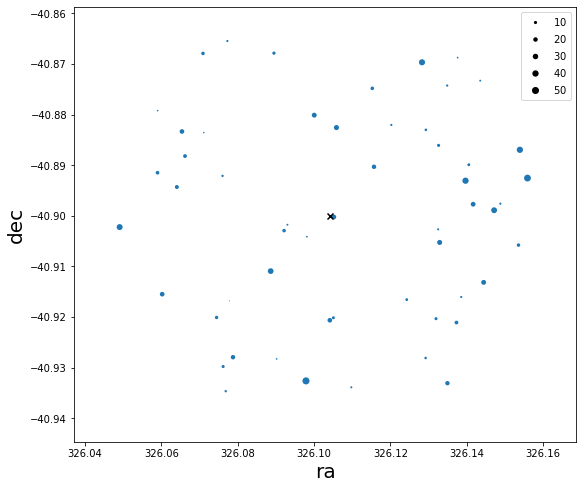

In [172]:
col0 = ra   #ra
col1 = dec   #dec

# 2D-histogram of objects
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.scatter(col0, col1, marker='o', s = -(50-1)/(max(rmag)-min(rmag)) * rmag + ((50-1)/(max(rmag)-min(rmag)) * max(rmag)+1), lw=0)
ax1.scatter(RA180924,DEC180924, marker='x', color='black')
#ax1.annotate('FRB180924', xy = (RA180924,DEC180924),xytext = (RA180924+0.02,DEC180924+0.02))
ax1.set_xlabel('ra',fontsize=20)
ax1.set_ylabel('dec',fontsize=20)
ax1.legend(*im1.legend_elements("sizes", num=5))


# generate wide1 + wide2 master file

19.79953956604 15.1862192153931


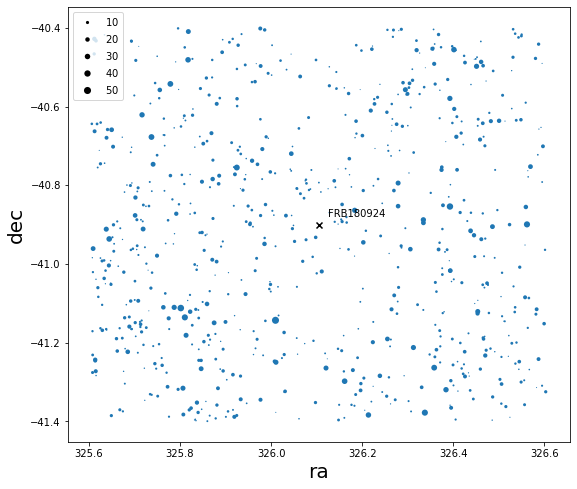

In [78]:
col0 = ra   #ra
col1 = dec   #dec

# 2D-histogram of objects
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.scatter(col0, col1, marker='o', s = -(50-1)/(max(rmag)-min(rmag)) * rmag + ((50-1)/(max(rmag)-min(rmag)) * max(rmag)+1), lw=0)
ax1.scatter(RA180924,DEC180924, marker='x', color='black')
ax1.annotate('FRB180924', xy = (RA180924,DEC180924),xytext = (RA180924+0.02,DEC180924+0.02))
ax1.set_xlabel('ra',fontsize=20)
ax1.set_ylabel('dec',fontsize=20)
ax1.legend(*im1.legend_elements("sizes", num=5))

print(max(rmag),min(rmag))

#plt.savefig('frb180924_auto_19.8_1df_753.png')

19.8435 15.5017


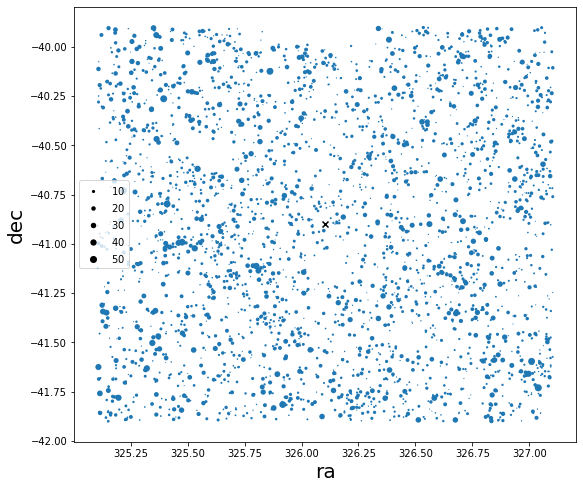

In [54]:
col0 = ra   #ra
col1 = dec   #dec

# 2D-histogram of objects
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.scatter(col0, col1, marker='o', s = -(50-1)/(max(rmag_aper)-min(rmag_aper)) * rmag_aper + ((50-1)/(max(rmag_aper)-min(rmag_aper)) * max(rmag_aper)+1), lw=0)
ax1.scatter(RA180924,DEC180924, marker='x', color='black')
#ax1.annotate('FRB180924', xy = (RA180924,DEC180924),xytext = (RA180924+0.02,DEC180924+0.02))
ax1.set_xlabel('ra',fontsize=20)
ax1.set_ylabel('dec',fontsize=20)
ax1.legend(*im1.legend_elements("sizes", num=5))

print(max(rmag_aper),min(rmag_aper))

#plt.savefig('frb180924_aper_19.844_2df_2934.png')


In [175]:
dt = np.dtype([('name','U15'),('RA.h','i1'),('RA.m','i1'),('RA.s','f8'),('dec.d','i1'),('dec.m','i1'),('dec.s','f8'),
              ('type','U5'),('prt','i1'),('mag','f4'),('Prog_ID','i1'),('PM_ra','f8'),('PM_dec','f8'),('cmt','U50')])
N=len(ra)
arr0 = np.zeros(N,dtype=dt)

In [176]:
N

55

In [178]:
arr0[:]['name']=idd
c = SkyCoord(ra*u.degree, dec*u.degree, frame='icrs')
arr0[:]['RA.h']=np.rint(c[:].ra.hms[0])
arr0[:]['RA.m']=np.rint(c[:].ra.hms[1])
arr0[:]['RA.s']=c[:].ra.hms[2]
arr0[:]['dec.d']=np.rint(c[:].dec.dms[0])
arr0[:]['dec.m']=np.rint(abs(c[:].dec.dms[1]))
arr0[:]['dec.s']=abs(c[:].dec.dms[2])
arr0[:]['type']=np.full(N,'P')
arr0[:]['prt']=np.full(N,9)
arr0[:]['mag']=rmag_aper
arr0[:]['Prog_ID']=np.full(N,1)

In [181]:
arr0

array([('209916730', 21, 44, 18.45408, -40, 56,  4.7148, 'P', 9, 21.7271, 1, 0., 0., ''),
       ('209914516', 21, 44, 11.78712, -40, 54,  7.9884, 'P', 9, 19.7361, 1, 0., 0., ''),
       ('209916192', 21, 44, 18.91152, -40, 55, 40.5336, 'P', 9, 20.8745, 1, 0., 0., ''),
       ('209913368', 21, 44, 14.17344, -40, 52, 45.174 , 'P', 9, 21.817 , 1, 0., 0., ''),
       ('209914185', 21, 44, 15.38184, -40, 53, 39.4944, 'P', 9, 20.9625, 1, 0., 0., ''),
       ('209916433', 21, 44, 18.2904 , -40, 55, 47.1828, 'P', 9, 21.8512, 1, 0., 0., ''),
       ('209914026', 21, 44, 14.16792, -40, 53, 29.3208, 'P', 9, 21.1353, 1, 0., 0., ''),
       ('209913845', 21, 44, 15.89568, -40, 53, 17.4912, 'P', 9, 21.0334, 1, 0., 0., ''),
       ('209913482', 21, 44, 15.70416, -40, 52, 59.988 , 'P', 9, 20.7026, 1, 0., 0., ''),
       ('209913603', 21, 44, 17.07576, -40, 53,  0.798 , 'P', 9, 21.9067, 1, 0., 0., ''),
       ('209912738', 21, 44, 17.02632, -40, 52,  4.4652, 'P', 9, 21.2054, 1, 0., 0., ''),
       ('2

In [182]:
f = open("FRB180924_22.0_narrow.txt",'a')
for i in range(N):
    f.write('{:<11s}   {:0>+3d} {:0>2d} {:0>6.3f}   {:0>+3d} {:0>2d} {:0>6.3f}   {:<5s}{:<4d}{:0>6.3f}   {:<4d}{:<+8.4f}{:<+8.4f}{:<30s}'.format(
    arr0[i]['name'],arr0[i]['RA.h'],arr0[i]['RA.m'],arr0[i]['RA.s'],arr0[i]['dec.d'],arr0[i]['dec.m'],arr0[i]['dec.s'],
    arr0[i]['type'],arr0[i]['prt'],arr0[i]['mag'],arr0[i]['Prog_ID'],arr0[i]['PM_ra'],arr0[i]['PM_dec'],arr0[i]['cmt']))
    f.write('\n') 
f.close()

# FRB191001 323.35 -54.748333333333335
#wide: ra_range = 1.9058 dec_range = 1.1
#narrow: ra_range = 0.0722 dec_range = 0.0417

# generate narrow list for calculating photometric redshift

In [140]:
# Write query statement (sql) as a string
# NOTE: triple quotes allow us to break the string on multiple lines
query = """
        SELECT coadd_object_id as id, mag_auto_r as rmag, mag_aper_8_r as rmag_aper, 
               class_star_g, class_star_r, class_star_z, 
               snr_g, snr_r, snr_z, ra, dec
        FROM des_dr1.main 
        WHERE (ra-(323.35)<0.0722 and ra-(323.35)>-0.0722 and dec-(-54.75)<0.0417 and dec-(-54.75)>-0.0417
                and snr_g>5 and snr_r>5 and snr_z>5 
                and class_star_r<0.5 and class_star_g<0.5 and class_star_z<0.5
                and mag_aper_8_r<22 and mag_aper_8_r>0 and mag_auto_r>0 and mag_auto_r<21)
        LIMIT 500"""

# mag_auto_g,r,i,z,y = AB magnitudes in DECam g,r,i,z,y bands
# class_star_g,r,z   = star/extended source classifier (from 0 to 1)
# snr_g,r,z          = computed signal-to-noise ratios (S/N) in g,r,z bands
# ra,dec             = celestial coordinates

print(query)


        SELECT coadd_object_id as id, mag_auto_r as rmag, mag_aper_8_r as rmag_aper, 
               class_star_g, class_star_r, class_star_z, 
               snr_g, snr_r, snr_z, ra, dec
        FROM des_dr1.main 
        WHERE (ra-(323.35)<0.0722 and ra-(323.35)>-0.0722 and dec-(-54.75)<0.0417 and dec-(-54.75)>-0.0417
                and snr_g>5 and snr_r>5 and snr_z>5 
                and class_star_r<0.5 and class_star_g<0.5 and class_star_z<0.5
                and mag_aper_8_r<22 and mag_aper_8_r>0 and mag_auto_r>23.5 and mag_auto_r<24)
        LIMIT 500


In [141]:
%%time
# Execute the query synchronously, if short (e.g., LIMIT<=300,000)
# We then convert the returned result, a CSV-formatted string, to a Pandas data frame,
# making sure that any potential 'Infinity' values are converted to NaN.
res1 = qc.query(sql=query)
df13 = convert(res1,'pandas')

CPU times: user 39 ms, sys: 1 ms, total: 40 ms
Wall time: 3min 31s


In [9]:
# Write query statement (sql) as a string
# NOTE: triple quotes allow us to break the string on multiple lines
query = """
        SELECT coadd_object_id as id, mag_auto_r as rmag, mag_aper_8_r as rmag_aper, 
               class_star_g, class_star_r, class_star_z, 
               snr_g, snr_r, snr_z, ra, dec,
               mag_auto_g_dered, magerr_auto_g, mag_auto_r_dered, magerr_auto_r, mag_auto_i_dered, magerr_auto_i, mag_auto_z_dered, magerr_auto_z
        FROM des_dr1.main 
        WHERE (ra-(323.35)<0.0722 and ra-(323.35)>-0.0722 and dec-(-54.75)<0.0417 and dec-(-54.75)>-0.0417
                and snr_g>5 and snr_r>5 and snr_z>5 
                and class_star_r<0.5 and class_star_g<0.5 and class_star_z<0.5
                and mag_aper_8_r<22 and mag_aper_8_r>0 and mag_auto_r>21 and mag_auto_r<22.5)
        LIMIT 500"""

# mag_auto_g,r,i,z,y = AB magnitudes in DECam g,r,i,z,y bands
# class_star_g,r,z   = star/extended source classifier (from 0 to 1)
# snr_g,r,z          = computed signal-to-noise ratios (S/N) in g,r,z bands
# ra,dec             = celestial coordinates

print(query)


        SELECT coadd_object_id as id, mag_auto_r as rmag, mag_aper_8_r as rmag_aper, 
               class_star_g, class_star_r, class_star_z, 
               snr_g, snr_r, snr_z, ra, dec,
               mag_auto_g_dered, magerr_auto_g, mag_auto_r_dered, magerr_auto_r, mag_auto_i_dered, magerr_auto_i, mag_auto_z_dered, magerr_auto_z
        FROM des_dr1.main 
        WHERE (ra-(323.35)<0.0722 and ra-(323.35)>-0.0722 and dec-(-54.75)<0.0417 and dec-(-54.75)>-0.0417
                and snr_g>5 and snr_r>5 and snr_z>5 
                and class_star_r<0.5 and class_star_g<0.5 and class_star_z<0.5
                and mag_aper_8_r<22 and mag_aper_8_r>0 and mag_auto_r>21 and mag_auto_r<22.5)
        LIMIT 500


In [10]:
%%time
# Execute the query synchronously, if short (e.g., LIMIT<=300,000)
# We then convert the returned result, a CSV-formatted string, to a Pandas data frame,
# making sure that any potential 'Infinity' values are converted to NaN.
res1 = qc.query(sql=query)
df14 = convert(res1,'pandas')

CPU times: user 30 ms, sys: 3 ms, total: 33 ms
Wall time: 3min 48s


In [74]:
ra = df13['ra'][:]
dec = df13['dec'][:]
rmag = df13['rmag'][:]
rmag_aper = df13['rmag_aper'][:]
idd = df13['id'][:]

g = SkyCoord(ra, dec, frame="icrs", unit="deg")

cen = ["21h33m24s -54d44m54s","21h44m25s -40d54m0s","21h49m23s -52d58m15s","21h49m23s -52d58m15s"]
cp = [cen[0]]*len(ra)
f = SkyCoord(cp, frame='icrs')

infield = g.separation(f).degree
incir = np.where(infield<0.0417)

ra = np.array(ra)[incir]
dec = np.array(dec)[incir]
rmag = np.array(rmag)[incir]
rmag_aper = np.array(rmag_aper)[incir]
idd = np.array(idd)[incir]

len(ra)

29

In [32]:
df15 = df13[np.in1d(df13['id'], idd)]

In [33]:
ra = df14['ra'][:]
dec = df14['dec'][:]
rmag = df14['rmag'][:]
rmag_aper = df14['rmag_aper'][:]
idd = df14['id'][:]

g = SkyCoord(ra, dec, frame="icrs", unit="deg")

cen = ["21h33m24s -54d44m54s","21h44m25s -40d54m0s","21h49m23s -52d58m15s","21h49m23s -52d58m15s"]
cp = [cen[0]]*len(ra)
f = SkyCoord(cp, frame='icrs')

infield = g.separation(f).degree
incir = np.where(infield<0.0417)

ra = np.array(ra)[incir]
dec = np.array(dec)[incir]
rmag = np.array(rmag)[incir]
rmag_aper = np.array(rmag_aper)[incir]
idd = np.array(idd)[incir]

len(ra)

32

In [42]:
df16 = df14[np.in1d(df14['id'], idd)]

In [43]:
len(df16)

32

In [70]:
outputfil = 'FRB191001_narrow_list.txt'
f = open(outputfil, 'w+')

for i in range(len(df15)):
    outstr = '{0:12d}   {1:7.4f}  {2:08.6f}  {3:7.4f}  {4:08.6f}  {5:7.4f}  {6:08.6f}  {7:7.4f}  {8:08.6f}\n'.format(np.array(df15['id'])[i], np.array(df15['mag_auto_g_dered'])[i], np.array(df15['magerr_auto_g'])[i], np.array(df15['mag_auto_r_dered'])[i], np.array(df15['magerr_auto_r'])[i], np.array(df15['mag_auto_i_dered'])[i], np.array(df15['magerr_auto_i'])[i], np.array(df15['mag_auto_z_dered'])[i], np.array(df15['magerr_auto_z'])[i])
    f.write(outstr)
    
for i in range(len(df16)):
    outstr = '{0:12d}   {1:7.4f}  {2:08.6f}  {3:7.4f}  {4:08.6f}  {5:7.4f}  {6:08.6f}  {7:7.4f}  {8:08.6f}\n'.format(np.array(df16['id'])[i], np.array(df16['mag_auto_g_dered'])[i], np.array(df16['magerr_auto_g'])[i], np.array(df16['mag_auto_r_dered'])[i], np.array(df16['magerr_auto_r'])[i], np.array(df16['mag_auto_i_dered'])[i], np.array(df16['magerr_auto_i'])[i], np.array(df16['mag_auto_z_dered'])[i], np.array(df16['magerr_auto_z'])[i])
    f.write(outstr)
    
f.close()

# generate narrow master file & wide1 + wide2 master file

In [143]:
print(df1[:5])
len(df1)

          id     rmag  rmag_aper  class_star_g  class_star_r  class_star_z  \
0  206898147  21.7395    21.6500      0.010636      0.027314      0.016668   
1  206897760  21.8076    21.6071      0.070562      0.116154      0.386656   
2  206896737  20.1388    20.1471      0.028538      0.028695      0.027907   
3  206896288  19.2574    19.4499      0.028560      0.028566      0.018116   
4  206897915  21.2137    21.2112      0.010216      0.027155      0.028035   

      snr_g     snr_r    snr_z          ra        dec  
0   22.1780   47.6152  24.5107  323.286456 -54.751560  
1   23.9393   48.3885  59.1030  323.311836 -54.746277  
2  127.8330  131.4990  54.5818  323.349777 -54.731717  
3  213.5860  189.0570  61.9972  323.352215 -54.727236  
4   18.7599   59.1178  48.5239  323.286749 -54.748802  


71

In [383]:
ra = df1['ra'][:]
dec = df1['dec'][:]
rmag = df1['rmag'][:]
rmag_aper = df1['rmag_aper'][:]
idd = df1['id'][:]

In [188]:
ra = df1['ra'][:]
dec = df1['dec'][:]
rmag = df1['rmag'][:]
rmag_aper = df1['rmag_aper'][:]
idd = df1['id'][:]
#iin = np.where((rmag<19.4)*(ra-(323.35)<0.5)*(ra-(323.35)>-0.5)*(dec-(-54.75)<0.5)*(dec-(-54.75)>-0.5))
iin = np.where((rmag_aper>=0) * (rmag_aper<22))
ra = np.array(ra)[iin]
dec = np.array(dec)[iin]
rmag = np.array(rmag)[iin]
rmag_aper = np.array(rmag_aper)[iin]
idd = np.array(idd)[iin]

len(ra)

71

In [192]:
g = SkyCoord(ra, dec, frame="icrs", unit="deg")

cen = ["21h33m24s -54d44m54s","21h44m25s -40d54m0s","21h49m23s -52d58m15s","21h49m23s -52d58m15s"]
cp = [cen[0]]*len(ra)
f = SkyCoord(cp, frame='icrs')

infield = g.separation(f).degree
incir = np.where(infield<0.0417)

ra = np.array(ra)[incir]
dec = np.array(dec)[incir]
rmag = np.array(rmag)[incir]
rmag_aper = np.array(rmag_aper)[incir]
idd = np.array(idd)[incir]

len(ra)

61

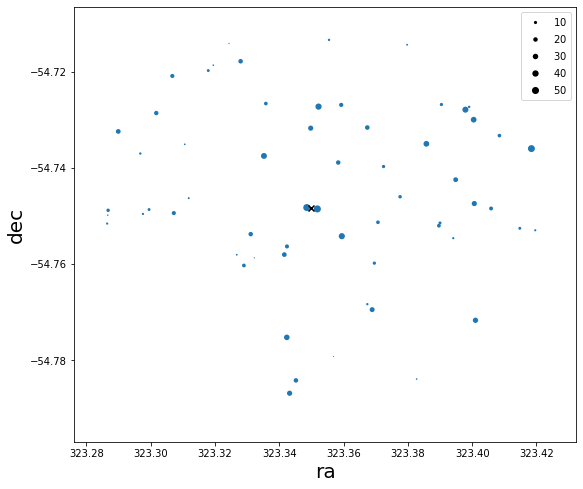

In [187]:
col0 = ra   #ra
col1 = dec   #dec

# 2D-histogram of objects
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.scatter(col0, col1, marker='o', s = -(50-1)/(max(rmag)-min(rmag)) * rmag + ((50-1)/(max(rmag)-min(rmag)) * max(rmag)+1), lw=0)
ax1.scatter(RA191001,DEC191001, marker='x', color='black')
#ax1.annotate('FRB191001', xy = (RA191001,DEC191001),xytext = (RA191001+0.02,DEC191001+0.02))
ax1.set_xlabel('ra',fontsize=20)
ax1.set_ylabel('dec',fontsize=20)
ax1.legend(*im1.legend_elements("sizes", num=5))

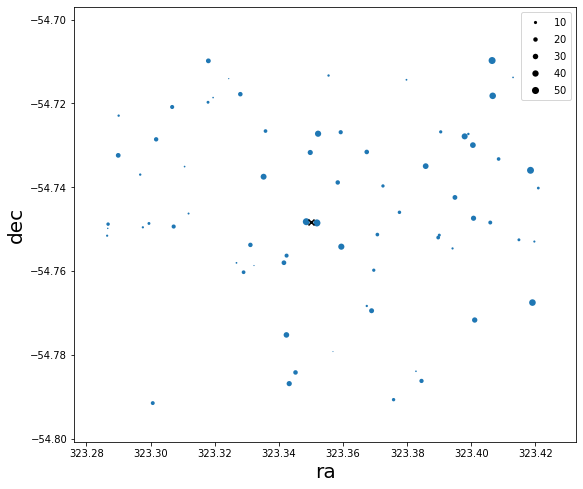

In [190]:
col0 = ra   #ra
col1 = dec   #dec

# 2D-histogram of objects
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.scatter(col0, col1, marker='o', s = -(50-1)/(max(rmag)-min(rmag)) * rmag + ((50-1)/(max(rmag)-min(rmag)) * max(rmag)+1), lw=0)
ax1.scatter(RA191001,DEC191001, marker='x', color='black')
#ax1.annotate('FRB191001', xy = (RA191001,DEC191001),xytext = (RA191001+0.02,DEC191001+0.02))
ax1.set_xlabel('ra',fontsize=20)
ax1.set_ylabel('dec',fontsize=20)
ax1.legend(*im1.legend_elements("sizes", num=5))

19.3995742797852 14.933614730834998


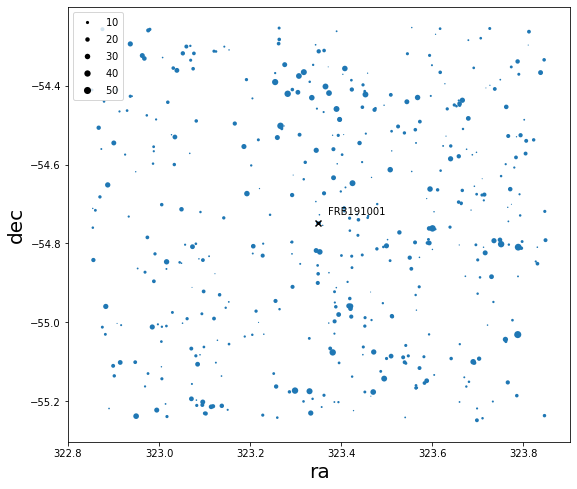

In [84]:
col0 = ra   #ra
col1 = dec   #dec

# 2D-histogram of objects
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.scatter(col0, col1, marker='o', s = -(50-1)/(max(rmag)-min(rmag)) * rmag + ((50-1)/(max(rmag)-min(rmag)) * max(rmag)+1), lw=0)
ax1.scatter(RA191001,DEC191001, marker='x', color='black')
ax1.annotate('FRB191001', xy = (RA191001,DEC191001),xytext = (RA191001+0.02,DEC191001+0.02))
ax1.set_xlabel('ra',fontsize=20)
ax1.set_ylabel('dec',fontsize=20)
ax1.legend(*im1.legend_elements("sizes", num=5))

print(max(rmag),min(rmag))

#plt.savefig('frb191001_auto_19.4_1df_464.png')

19.4656 15.5366


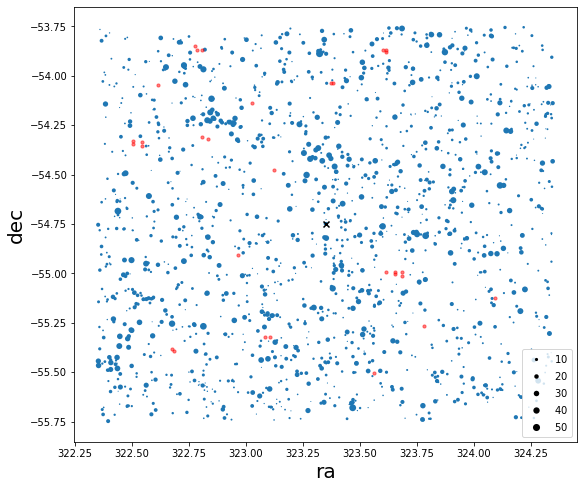

In [969]:
col0 = ra   #ra
col1 = dec   #dec

# 2D-histogram of objects
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.scatter(col0, col1, marker='o', s = -(50-1)/(max(rmag_aper)-min(rmag_aper)) * rmag_aper + ((50-1)/(max(rmag_aper)-min(rmag_aper)) * max(rmag_aper)+1), lw=0)
ax1.scatter(RA191001,DEC191001, marker='x', color='black')
#ax1.scatter(blkx,blky, marker='o', color='red', alpha = 0.5, s = 10)
#ax1.annotate('FRB191001', xy = (RA191001,DEC191001),xytext = (RA191001+0.02,DEC191001+0.02))
ax1.set_xlabel('ra',fontsize=20)
ax1.set_ylabel('dec',fontsize=20)
ax1.legend(*im1.legend_elements("sizes", num=5))

print(max(rmag_aper),min(rmag_aper))

#plt.savefig('frb191001_aper_19.466_2df_1588.png')

In [193]:
N=len(ra)
print(N)
arr1 = np.zeros(N,dtype=dt)

arr1[:]['name']=idd
c = SkyCoord(ra*u.degree, dec*u.degree, frame='icrs')
arr1[:]['RA.h']=np.rint(c[:].ra.hms[0])
arr1[:]['RA.m']=np.rint(c[:].ra.hms[1])
arr1[:]['RA.s']=c[:].ra.hms[2]
arr1[:]['dec.d']=np.rint(c[:].dec.dms[0])
arr1[:]['dec.m']=np.rint(abs(c[:].dec.dms[1]))
arr1[:]['dec.s']=abs(c[:].dec.dms[2])
arr1[:]['type']=np.full(N,'P')
arr1[:]['prt']=np.full(N,9)
arr1[:]['mag']=rmag_aper
arr1[:]['Prog_ID']=np.full(N,0)

61


In [194]:
arr1

array([('206898147', 21, 33,  8.74944, -54, 45,  5.616 , 'P', 9, 21.65  , 0, 0., 0., ''),
       ('206897760', 21, 33, 14.84064, -54, 44, 46.5972, 'P', 9, 21.6071, 0, 0., 0., ''),
       ('206896737', 21, 33, 23.94648, -54, 43, 54.1812, 'P', 9, 20.1471, 0, 0., 0., ''),
       ('206896288', 21, 33, 24.5316 , -54, 43, 38.0496, 'P', 9, 19.4499, 0, 0., 0., ''),
       ('206897915', 21, 33,  8.81976, -54, 44, 55.6872, 'P', 9, 21.2112, 0, 0., 0., ''),
       ('206897953', 21, 33, 11.42136, -54, 44, 58.4196, 'P', 9, 21.8235, 0, 0., 0., ''),
       ('206896508', 21, 33, 12.41544, -54, 43, 42.8736, 'P', 9, 20.6695, 0, 0., 0., ''),
       ('206897148', 21, 33, 11.22312, -54, 44, 13.1532, 'P', 9, 21.6768, 0, 0., 0., ''),
       ('206896982', 21, 33, 14.54424, -54, 44,  6.2736, 'P', 9, 21.8777, 0, 0., 0., ''),
       ('206897514', 21, 33, 23.652  , -54, 44, 53.6064, 'P', 9, 18.6639, 0, 0., 0., ''),
       ('206896724', 21, 33, 28.17336, -54, 43, 53.7168, 'P', 9, 20.5065, 0, 0., 0., ''),
       ('2

In [195]:
f = open("FRB191001_22.0_narrow.txt",'a')
for i in range(N):
    f.write('{:<11s}   {:0>+3d} {:0>2d} {:0>6.3f}   {:0>+3d} {:0>2d} {:0>6.3f}   {:<5s}{:<4d}{:0>6.3f}   {:<4d}{:<+8.4f}{:<+8.4f}{:<30s}'.format(
    arr1[i]['name'],arr1[i]['RA.h'],arr1[i]['RA.m'],arr1[i]['RA.s'],arr1[i]['dec.d'],arr1[i]['dec.m'],arr1[i]['dec.s'],
    arr1[i]['type'],arr1[i]['prt'],arr1[i]['mag'],arr1[i]['Prog_ID'],arr1[i]['PM_ra'],arr1[i]['PM_dec'],arr1[i]['cmt']))
    f.write('\n') 
f.close()

# FRB181112  RA = 327.346, Dec = -52.971

In [380]:
print(RA181112, DEC181112)

327.3458333333333 -52.97083333333334


In [ ]:
# select mag_aper_8_r<20.65 within d<1.1

# Write query statement (sql) as a string
# NOTE: triple quotes allow us to break the string on multiple lines
query = """
        SELECT coadd_object_id as id, mag_auto_r as rmag, mag_aper_8_r as rmag_aper, 
               class_star_g, class_star_r, class_star_z, 
               snr_g, snr_r, snr_z, ra, dec
        FROM des_dr1.main 
        WHERE (ra-(327.346)<1.8266 and ra-(327.346)>-1.8266 and dec-(-52.971)<1.1 and dec-(-52.971)>-1.1
                and snr_g>5 and snr_r>5 and snr_z>5 
                and class_star_r<0.5 and class_star_g<0.5 and class_star_z<0.5
                and mag_aper_8_r<20.65 and mag_aper_8_r>0 and mag_auto_r>0 and mag_auto_r<25)
        LIMIT 50000"""

# mag_auto_g,r,i,z,y = AB magnitudes in DECam g,r,i,z,y bands
# class_star_g,r,z   = star/extended source classifier (from 0 to 1)
# snr_g,r,z          = computed signal-to-noise ratios (S/N) in g,r,z bands
# ra,dec             = celestial coordinates

print(query)

In [388]:
%%time
# Execute the query synchronously, if short (e.g., LIMIT<=300,000)
# We then convert the returned result, a CSV-formatted string, to a Pandas data frame,
# making sure that any potential 'Infinity' values are converted to NaN.
res2 = qc.query(sql=query)
df2 = convert(res2,'pandas')

CPU times: user 77 ms, sys: 8 ms, total: 85 ms
Wall time: 4min 55s


In [389]:
print(df2[:5])
len(df2)

          id     rmag  rmag_aper  class_star_g  class_star_r  class_star_z  \
0  209950514  20.2211    20.1913      0.108404      0.029988      0.028902   
1  209951404  20.4529    20.4253      0.026350      0.028995      0.028724   
2  209951345  20.5627    20.5384      0.009106      0.028938      0.028424   
3  209952524  19.0921    19.3171      0.028360      0.028667      0.028645   
4  209815895  20.1408    20.1914      0.023857      0.028671      0.027845   

     snr_g    snr_r    snr_z          ra        dec  
0  29.2812  83.6347  65.7238  325.556958 -54.041264  
1  35.4506  70.8412  51.8411  325.527930 -54.052290  
2  24.7076  60.4905  47.8314  325.532034 -54.051254  
3  29.3164  80.2453  83.7329  325.534479 -54.070329  
4  46.7237  75.4309  52.8526  325.526084 -54.006522  


11131

In [390]:
ra = df2['ra'][:]
dec = df2['dec'][:]
rmag = df2['rmag'][:]
rmag_aper = df2['rmag_aper'][:]
idd = df2['id'][:]

In [391]:
ra = df2['ra'][:]
dec = df2['dec'][:]
rmag = df2['rmag'][:]
rmag_aper = df2['rmag_aper'][:]
idd = df2['id'][:]
#iin = np.where((rmag<20.6)*(ra-(327.346)<0.5)*(ra-(327.346)>-0.5)*(dec-(-52.971)<0.5)*(dec-(-52.971)>-0.5))
iin = np.where((rmag_aper<19.844))
ra = np.array(ra)[iin]
dec = np.array(dec)[iin]
rmag = np.array(rmag)[iin]
rmag_aper = np.array(rmag_aper)[iin]
idd = np.array(idd)[iin]

len(ra)

4414

In [409]:
ra = df2['ra'][:]
dec = df2['dec'][:]
rmag = df2['rmag'][:]
rmag_aper = df2['rmag_aper'][:]
idd = df2['id'][:]
#iin = np.where((rmag<20.6)*(ra-(327.346)<0.5)*(ra-(327.346)>-0.5)*(dec-(-52.971)<0.5)*(dec-(-52.971)>-0.5))
iin = np.where((rmag_aper>=19.844)&(rmag_aper<20.649))
ra = np.array(ra)[iin]
dec = np.array(dec)[iin]
rmag = np.array(rmag)[iin]
rmag_aper = np.array(rmag_aper)[iin]
idd = np.array(idd)[iin]

len(ra)

6700

20.5991497039795 13.600948333740199


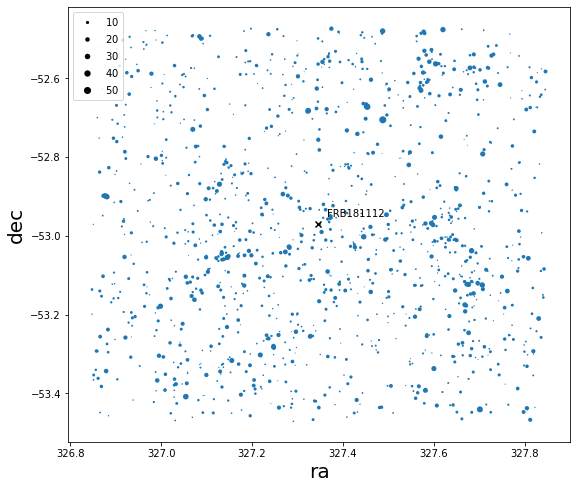

In [109]:
col0 = ra   #ra
col1 = dec   #dec

# 2D-histogram of objects
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.scatter(col0, col1, marker='o', s = -(50-1)/(max(rmag)-min(rmag)) * rmag + ((50-1)/(max(rmag)-min(rmag)) * max(rmag)+1), lw=0)
ax1.scatter(RA181112,DEC181112, marker='x', color='black')
ax1.annotate('FRB181112', xy = (RA181112,DEC181112),xytext = (RA181112+0.02,DEC181112+0.02))
ax1.set_xlabel('ra',fontsize=20)
ax1.set_ylabel('dec',fontsize=20)
ax1.legend(*im1.legend_elements("sizes", num=5))

print(max(rmag),min(rmag))

plt.savefig('frb181112_auto_20.6_1df_1250.png')

20.6489 14.9441


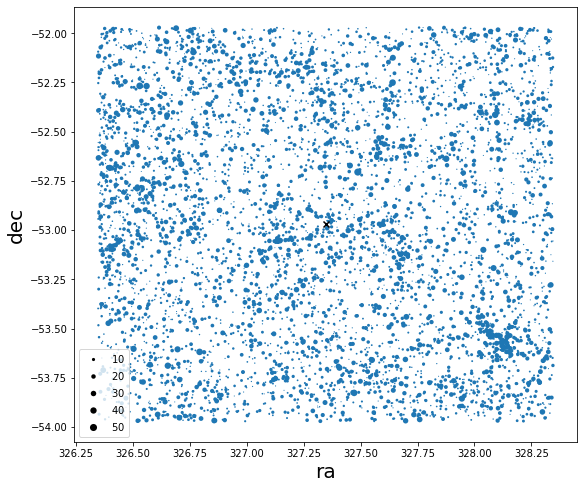

In [29]:
col0 = ra   #ra
col1 = dec   #dec

# 2D-histogram of objects
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.scatter(col0, col1, marker='o', s = -(50-1)/(max(rmag_aper)-min(rmag_aper)) * rmag_aper + ((50-1)/(max(rmag_aper)-min(rmag_aper)) * max(rmag_aper)+1), lw=0)
ax1.scatter(RA181112,DEC181112, marker='x', color='black')
#ax1.annotate('FRB181112', xy = (RA181112,DEC181112),xytext = (RA181112+0.02,DEC181112+0.02))
ax1.set_xlabel('ra',fontsize=20)
ax1.set_ylabel('dec',fontsize=20)
ax1.legend(*im1.legend_elements("sizes", num=5))

print(max(rmag_aper),min(rmag_aper))

#plt.savefig('frb181112_aper_20.649_2df_5638.png')

In [410]:
c = SkyCoord(ra*u.degree, dec*u.degree, frame='icrs')

In [411]:
dt = np.dtype([('name','U10'),('RA.h','i1'),('RA.m','i1'),('RA.s','f8'),('dec.d','i1'),('dec.m','i1'),('dec.s','f8'),
              ('type','U5'),('prt','i1'),('mag','f4'),('Prog_ID','i1'),('PM_ra','f8'),('PM_dec','f8'),('cmt','U50')])

In [412]:
N=len(ra)
print(N)

6700


In [413]:
arr2 = np.zeros(N,dtype=dt)
arr2[:]['name']=idd
arr2[:]['RA.h']=np.rint(c[:].ra.hms[0])
arr2[:]['RA.m']=np.rint(c[:].ra.hms[1])
arr2[:]['RA.s']=c[:].ra.hms[2]
arr2[:]['dec.d']=np.rint(c[:].dec.dms[0])
arr2[:]['dec.m']=np.rint(abs(c[:].dec.dms[1]))
arr2[:]['dec.s']=abs(c[:].dec.dms[2])
arr2[:]['type']=np.full(N,'P')
arr2[:]['prt']=np.full(N,9)
arr2[:]['mag']=rmag_aper
arr2[:]['Prog_ID']=np.full(N,3)

In [425]:
arr2

array([('209950514', 21, 42, 13.66992, -54,  2, 28.5504, 'P', 9, 20.1913, 3, 0., 0., ''),
       ('209951404', 21, 42,  6.7032 , -54,  3,  8.244 , 'P', 9, 20.4253, 3, 0., 0., ''),
       ('209951345', 21, 42,  7.68816, -54,  3,  4.5144, 'P', 9, 20.5384, 3, 0., 0., ''),
       ...,
       ('245838860', 21, 56, 26.43   , -53, 51, 37.2132, 'P', 9, 20.393 , 3, 0., 0., ''),
       ('246102346', 21, 56, 28.3392 , -53, 53,  6.198 , 'P', 9, 20.0073, 3, 0., 0., ''),
       ('245839870', 21, 56, 26.39088, -53, 52, 44.5656, 'P', 9, 19.8928, 3, 0., 0., '')],
      dtype=[('name', '<U10'), ('RA.h', 'i1'), ('RA.m', 'i1'), ('RA.s', '<f8'), ('dec.d', 'i1'), ('dec.m', 'i1'), ('dec.s', '<f8'), ('type', '<U5'), ('prt', 'i1'), ('mag', '<f4'), ('Prog_ID', 'i1'), ('PM_ra', '<f8'), ('PM_dec', '<f8'), ('cmt', '<U50')])

In [240]:
'{:12s}{:<+4d}{:<3d}{:<9.3f}{:<+4d}{:<3d}{:<9.3f}{:<5s}{:<4d}{:<9.3f}{:<4d}{:<+8.4f}{:<+8.4f}{:<30s}'.format(
    arr2[0]['name'],arr2[0]['RA.h'],arr2[0]['RA.m'],arr2[0]['RA.s'],arr2[0]['dec.d'],arr2[0]['dec.m'],arr2[0]['dec.s'],
    arr2[0]['type'],arr2[0]['prt'],arr2[0]['mag'],arr2[0]['Prog_ID'],arr2[0]['PM_ra'],arr2[0]['PM_dec'],arr2[0]['cmt'])

112

In [426]:
f = open("FRB181112_p2.txt",'a')

for i in range(N):
    f.write('{:<11s}   {:0>+3d} {:0>2d} {:0>6.3f}   {:0>+3d} {:0>2d} {:0>6.3f}   {:<5s}{:<4d}{:0>6.3f}   {:<4d}{:<+8.4f}{:<+8.4f}{:<30s}'.format(
    arr2[i]['name'],arr2[i]['RA.h'],arr2[i]['RA.m'],arr2[i]['RA.s'],arr2[i]['dec.d'],arr2[i]['dec.m'],arr2[i]['dec.s'],
    arr2[i]['type'],arr2[i]['prt'],arr2[i]['mag'],arr2[i]['Prog_ID'],arr2[i]['PM_ra'],arr2[i]['PM_dec'],arr2[i]['cmt']))
    f.write('\n')
    
f.close()